## Title: The Impact of Sentiment on Stock Prices: Study of Tweets About Top Companies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
import os
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
from tqdm.notebook import trange, tqdm
#pd.get_option("display.max_columns")
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
#from numba import jit, cuda
from scipy import stats as stat

### All Dataset lodaded and store in dataframes

In [2]:
# Load the datasets
tweet_data = pd.read_csv('Tweets about the Top Companies from 2015 to 2020/tweet.csv')
company_tweet_data = pd.read_csv('Tweets about the Top Companies from 2015 to 2020/Company_Tweet.csv')
company_value_data = pd.read_csv('Values of Top NASDAQ Companies from 2010 to 2020/CompanyValues.csv')

# Merge 'tweet_data' and 'company_tweet_data' on 'tweet_id'
merged_tweets = pd.merge(tweet_data, company_tweet_data, on='tweet_id', how='inner')

# Remove duplicate tweets based on 'body' column
unique_tweets = merged_tweets.drop_duplicates("body")

# Convert the 'post_date' column to datetime format and then format it as 'YYYY-MM-DD'
unique_tweets['Date'] = pd.to_datetime(unique_tweets['post_date'], unit='s').dt.strftime('%Y-%m-%d')

# Create a new column 'total_engagement' as the sum of 'comment_num', 'retweet_num', and 'like_num'
unique_tweets["total_engagement"] = unique_tweets["comment_num"] + unique_tweets["retweet_num"] + unique_tweets["like_num"]

# Drop unnecessary columns and create a final DataFrame
final_tweet_data = unique_tweets.drop(['tweet_id','post_date', 'writer', 'comment_num', 'retweet_num', 'like_num'], axis=1)



### Bellow all setps to clean and prepareing the data to analysis

In [3]:
start_date = '2014-12-25'
end_date = '2019-12-31'

# Filter company values between the start and end date
company_values_filtered = company_value_data[(company_value_data['day_date'] >= start_date) &  (company_value_data['day_date'] <= end_date)]
company_values_filtered = company_values_filtered.sort_values(by=['ticker_symbol', 'day_date'])
company_values_filtered

final_data = pd.merge(final_tweet_data, company_values_filtered, 
                      left_on=['ticker_symbol','Date'], right_on=['ticker_symbol','day_date'], 
                      how='inner')
final_data = final_data.drop(['day_date'], axis=1)
final_data = final_data.sort_values(by=['ticker_symbol', 'Date'])


In [4]:
tickers = ['AAPL', 'AMZN', 'GOOG', 'GOOGL', 'MSFT', 'TSLA']

# Create an empty list to store DataFrames
dataframes = []

for ticker in tickers:
    # Filter company values by ticker symbol
    ticker_data = final_data[final_data['ticker_symbol'] == ticker]

    # Compute percent change in 'close_value'
    ticker_data['change'] = round(ticker_data['close_value'].pct_change(periods = 1) * 100, 2)

    # Append the DataFrame to the list
    dataframes.append(ticker_data)

# Concatenate all DataFrames
final_data = pd.concat(dataframes)
final_data
# Function to replace zero with last non-zero value in a pandas Series
def replace_zero_with_last_non_zero(s):
    # Replace 0 with NaN
    s = s.replace(0, np.nan)
    # Forward fill NaN values
    s = s.fillna(method='ffill')
    # Replace any remaining NaN with 0 (in case the first value(s) were 0)
    s = s.fillna(0)
    return s

# Apply function
final_data['change'] = final_data.groupby('ticker_symbol')['change'].transform(replace_zero_with_last_non_zero)
df = final_data
final_data = final_data[(final_data['Date'] >= "2016-01-01") & (final_data['Date'] <= "2016-12-31")]
final_data

,body,ticker_symbol,Date,total_engagement,close_value,volume,open_value,high_value,low_value,change
617298,10 Reasons why $AAPL is underpriced - part 2 h...,AAPL,2016-01-01,0,105.26,40885480,107.01,107.03,104.82,-1.92
617299,"""Apple stock closes first negative year since ...",AAPL,2016-01-01,1,105.26,40885480,107.01,107.03,104.82,-1.92
617300,I love stock picks as plays. That's cool. $aap...,AAPL,2016-01-01,4,105.26,40885480,107.01,107.03,104.82,-1.92
617301,Tickers trending on TWTR in last 1 hour $AAPL ...,AAPL,2016-01-01,1,105.26,40885480,107.01,107.03,104.82,-1.92
617302,"$GDAR Last Price Updated Thursday, December 31...",AAPL,2016-01-01,1,105.26,40885480,107.01,107.03,104.82,-1.92
...,...,...,...,...,...,...,...,...,...,...
1381076,"""New Year's experiment: is Autopilot written o...",TSLA,2016-12-31,1,213.69,4641288,216.30,217.50,211.68,-0.46
1381077,"Contrast to #Elonmusk , who implemented change...",TSLA,2016-12-31,0,213.69,4641288,216.30,217.50,211.68,-0.46
1381078,So @InsideEVs has $TSLA at 61.7k units thru No...,TSLA,2016-12-31,0,213.69,4641288,216.30,217.50,211.68,-0.46
1381079,http://bit.ly/2fry3Bj *Review* Easy low cost ...,TSLA,2016-12-31,0,213.69,4641288,216.30,217.50,211.68,-0.46


In [5]:
Group_final_data = final_data.groupby(['ticker_symbol', 'Date']).agg({
    'total_engagement': 'sum',
    'body': 'sum',
    'volume': 'mean',
    'close_value':'mean',
    'change': 'mean',
    'open_value':'mean',
    'high_value':'mean',
    'low_value':'mean',}).reset_index()
Group_final_data

,ticker_symbol,Date,total_engagement,body,volume,close_value,change,open_value,high_value,low_value
0,AAPL,2016-01-01,507,10 Reasons why $AAPL is underpriced - part 2 h...,40885480.0,105.26,-1.92,107.01,107.030,104.8200
1,AAPL,2016-01-02,524,Jim Chanos: 'I Don't Think Apple's a Value Sto...,40885480.0,105.26,-1.92,107.01,107.030,104.8200
2,AAPL,2016-01-03,537,AYI Aims to Be the LinkedIn of Online Dating $...,40885480.0,105.26,-1.92,107.01,107.030,104.8200
3,AAPL,2016-01-04,1836,RT $AAPL Allegation: CNBC spreads FUD to short...,67569090.0,105.35,0.09,102.61,105.368,102.0000
4,AAPL,2016-01-05,1908,The bozos are the ones who connected $USO to $...,55583140.0,102.71,-2.51,105.75,105.850,102.4100
...,...,...,...,...,...,...,...,...,...,...
2191,TSLA,2016-12-27,1260,$TSLA Technical Analysis Video to Prepare for...,5913335.0,219.53,2.90,214.88,222.250,214.4200
2192,TSLA,2016-12-28,846,"$BAC News Updated Tuesday, December 27, 2016 7...",3778544.0,219.74,0.10,221.53,223.800,217.2000
2193,TSLA,2016-12-29,589,+100@TeslaMotors#TeslaAutoPilot$TSLACOMMENTARY...,4043086.0,214.68,-2.30,218.56,219.200,214.1225
2194,TSLA,2016-12-30,791,That's a start- slides 136-152: http://busines...,4641288.0,213.69,-0.46,216.30,217.500,211.6800


### Comparision Total Engagement, Volume, and Change Over Time of each Company:

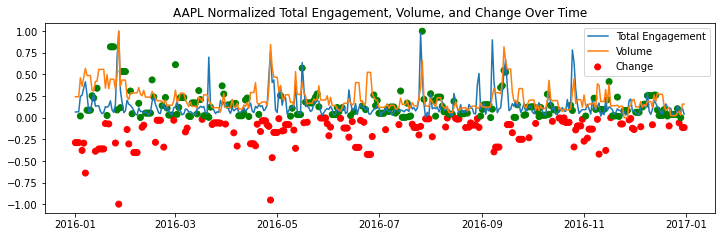

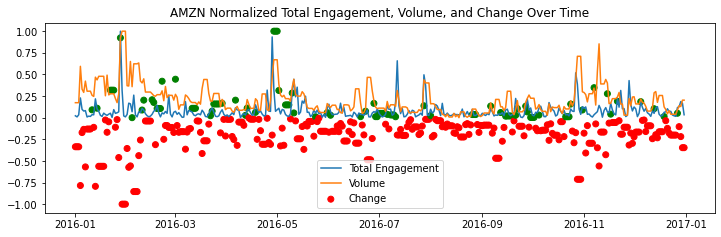

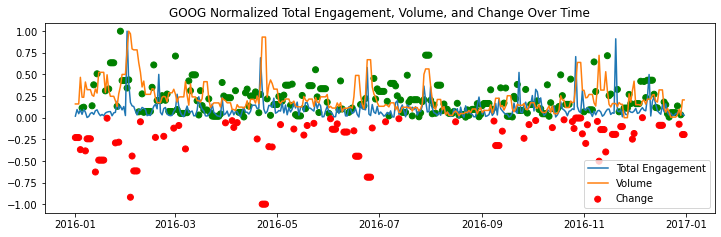

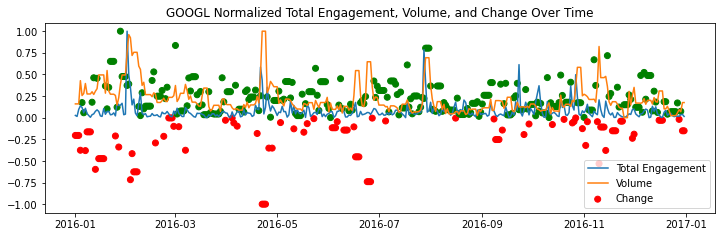

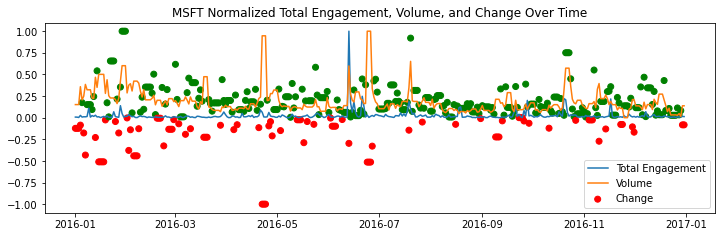

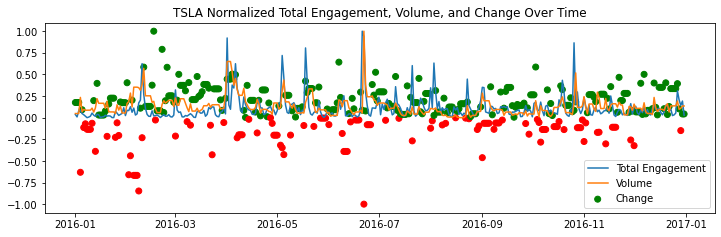

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Initialize two MinMaxScalers
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler(feature_range=(-1, 1))  # Scale to range (-1, 1) to keep negative 'change' values

# List of ticker symbols to consider
tickers = ['AAPL', 'AMZN', 'GOOG', 'GOOGL', 'MSFT', 'TSLA']

# Loop over each ticker symbol
for ticker in tickers:
    # Filter the data for the current ticker symbol
    data = Group_final_data[Group_final_data['ticker_symbol'] == ticker]

    # Convert 'Date' to datetime
    data['Date'] = pd.to_datetime(data['Date'])

    # Normalize 'total_engagement' and 'volume'
    data[['total_engagement', 'volume']] = scaler1.fit_transform(data[['total_engagement', 'volume']])

    # Normalize 'change' separately
    data[['change']] = scaler2.fit_transform(data[['change']])

    # Create a new figure for the current ticker symbol with adjusted width for A4 paper
    plt.figure(figsize=(12, 3.5))

    # Plot 'total_engagement' and 'volume'
    plt.plot(data['Date'], data['total_engagement'], label='Total Engagement')
    plt.plot(data['Date'], data['volume'], label='Volume')

    # Plot 'change' with different colors for positive and negative changes
    plt.scatter(data['Date'], data['change'], c=['g' if c > 0 else 'r' for c in data['change']], label='Change')

    # Add a legend
    plt.legend()

    # Add title
    plt.title(f'{ticker} Normalized Total Engagement, Volume, and Change Over Time')

    # Show the plot
    plt.show()


In [10]:
question4 = df
question4['year'] = pd.DatetimeIndex(question4['Date']).year
question4 = question4.groupby(['ticker_symbol','year']).agg({
    'total_engagement': 'sum',}).reset_index()
question4 = question4.sort_values(['ticker_symbol','year'])
# question4 = question4.drop(['close_value'])


In [11]:


# Market cap data for the companies
market_cap_data = {
    'AAPL': {2015: 600, 2016: 600, 2017: 900, 2018: 950, 2019: 1300},
    'AMZN': {2015: 250, 2016: 356, 2017: 600, 2018: 800, 2019: 925},
    'GOOG': {2015: 500, 2016: 520, 2017: 720, 2018: 730, 2019: 930},
    'MSFT': {2015: 400, 2016: 490, 2017: 650, 2018: 850, 2019: 1200},
    'TSLA': {2015: 30, 2016: 30, 2017: 50, 2018: 50, 2019: 75},
}

# Combine the total_engagement for GOOG and GOOGL
combined_google_df = question4[question4['ticker_symbol'].isin(['GOOG', 'GOOGL'])].groupby('year')['total_engagement'].sum().reset_index()
combined_google_df['ticker_symbol'] = 'GOOG'

# Define the 'Market_cap' column for the combined Google data
combined_google_df['Market_cap'] = combined_google_df['year'].map(market_cap_data['GOOG'])

# Remove the old Google rows
question4 = question4[~question4['ticker_symbol'].isin(['GOOG', 'GOOGL'])]

# Append the combined Google data
question4 = pd.concat([question4, combined_google_df], ignore_index=True)

# Add the market cap for the other companies
question4['Market_cap'] = question4.apply(lambda row: market_cap_data.get(row['ticker_symbol'], {}).get(row['year'], None) if row['ticker_symbol'] != 'GOOG' else row['Market_cap'], axis=1)

# Mapping of ticker symbols to company names
ticker_to_name = {
    'AAPL': 'Apple Inc.',
    'AMZN': 'Amazon.com Inc.',
    'GOOG': 'Google (Alphabet Inc.)',
    'MSFT': 'Microsoft Corporation',
    'TSLA': 'Tesla Inc.',
}

# Replace the ticker symbols with the company names
question4['ticker_symbol'] = question4['ticker_symbol'].map(ticker_to_name)

# Rename the 'ticker_symbol' column to 'company_name'
question4.rename(columns={'ticker_symbol': 'company_name'}, inplace=True)

# Preview the DataFrame
question4



,company_name,year,total_engagement,Market_cap
0,Apple Inc.,2015,383903,600.0
1,Apple Inc.,2016,378947,600.0
2,Apple Inc.,2017,338442,900.0
3,Apple Inc.,2018,516045,950.0
4,Apple Inc.,2019,555878,1300.0
5,Amazon.com Inc.,2015,76373,250.0
6,Amazon.com Inc.,2016,114489,356.0
7,Amazon.com Inc.,2017,233732,600.0
8,Amazon.com Inc.,2018,320483,800.0
9,Amazon.com Inc.,2019,289990,925.0


In [12]:
# Follower counts in 2023 (in millions)
follower_counts_2023 = {
    'Apple Inc.': 9.3,
    'Amazon.com Inc.': 5.6,
    'Google (Alphabet Inc.)': 30,
    'Microsoft Corporation': 13.2,
    'Tesla Inc.': 20.5,
}

# Assume follower counts in 2015 are 20% of the 2023 values
follower_counts_2015 = {company: 0.2 * count for company, count in follower_counts_2023.items()}

# Calculate the yearly growth rates for each company
growth_rates = {company: (follower_counts_2023[company] - follower_counts_2015[company]) / (2023 - 2015) for company in follower_counts_2023.keys()}

# Define a function to calculate the follower count for a given company and year
def calculate_follower_count(row):
    return follower_counts_2015[row['company_name']] + growth_rates[row['company_name']] * (row['year'] - 2015)

# Add a new column for the follower count
question4['follower_count'] = question4.apply(calculate_follower_count, axis=1)

# Preview the updated DataFrame
question4


,company_name,year,total_engagement,Market_cap,follower_count
0,Apple Inc.,2015,383903,600.0,1.86
1,Apple Inc.,2016,378947,600.0,2.79
2,Apple Inc.,2017,338442,900.0,3.72
3,Apple Inc.,2018,516045,950.0,4.65
4,Apple Inc.,2019,555878,1300.0,5.58
5,Amazon.com Inc.,2015,76373,250.0,1.12
6,Amazon.com Inc.,2016,114489,356.0,1.68
7,Amazon.com Inc.,2017,233732,600.0,2.24
8,Amazon.com Inc.,2018,320483,800.0,2.80
9,Amazon.com Inc.,2019,289990,925.0,3.36


### Checking does follower count affect the the price of stock!!

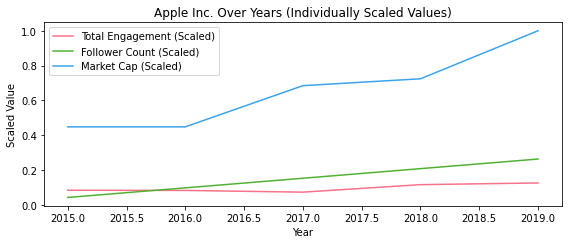

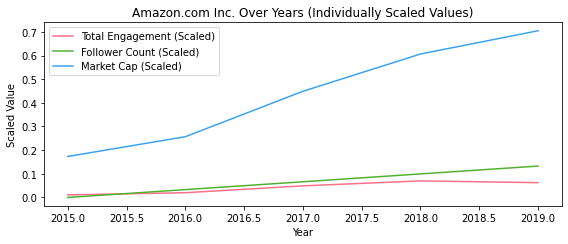

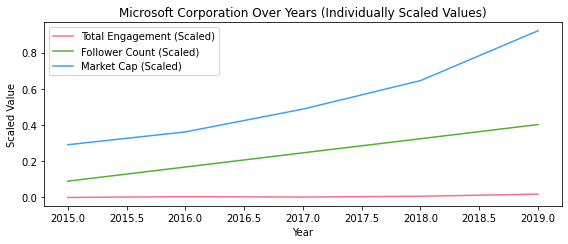

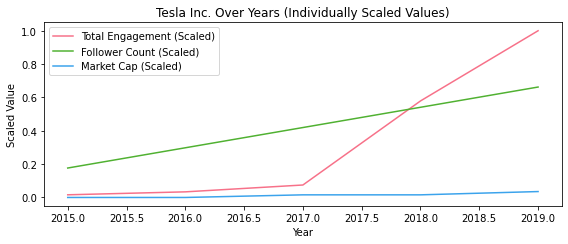

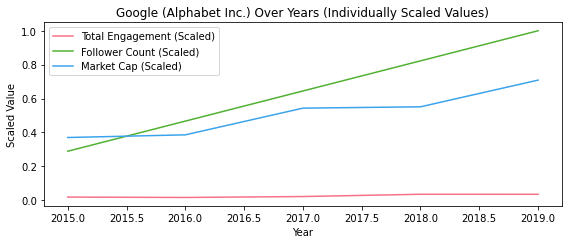

In [20]:
# Let's start by reimporting the necessary libraries and loading the data again.

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# Load the data
df = pd.read_csv('question4.csv')

# Replace the ticker symbols with the actual company names
company_names = {
    'AAPL': 'Apple Inc.',
    'AMZN': 'Amazon.com Inc.',
    'GOOG': 'Google (Alphabet Inc.)',
    'GOOGL': 'Google (Alphabet Inc.)',
    'MSFT': 'Microsoft Corporation',
    'TSLA': 'Tesla Inc.',
}
df['company_name'] = df['ticker_symbol'].replace(company_names)

# Combine the total_engagement for GOOG and GOOGL
combined_google_df = df[df['ticker_symbol'].isin(['GOOG', 'GOOGL'])].groupby('year')['total_engagement'].sum().reset_index()
combined_google_df['company_name'] = 'Google (Alphabet Inc.)'

# Remove the old Google rows
df = df[~df['ticker_symbol'].isin(['GOOG', 'GOOGL'])]

# Append the combined Google data
df = pd.concat([df, combined_google_df], ignore_index=True)

# Add the market cap data
market_cap_data = {
    'Apple Inc.': {2015: 600, 2016: 600, 2017: 900, 2018: 950, 2019: 1300},
    'Amazon.com Inc.': {2015: 250, 2016: 356, 2017: 600, 2018: 800, 2019: 925},
    'Google (Alphabet Inc.)': {2015: 500, 2016: 520, 2017: 720, 2018: 730, 2019: 930},
    'Microsoft Corporation': {2015: 400, 2016: 490, 2017: 650, 2018: 850, 2019: 1200},
    'Tesla Inc.': {2015: 30, 2016: 30, 2017: 50, 2018: 50, 2019: 75},
}
df['Market_cap'] = df.apply(lambda row: market_cap_data.get(row['company_name'], {}).get(row['year'], None), axis=1)

# Calculate the follower counts
follower_counts_2023 = {
    'Apple Inc.': 9.3,
    'Amazon.com Inc.': 5.6,
    'Google (Alphabet Inc.)': 30,
    'Microsoft Corporation': 13.2,
    'Tesla Inc.': 20.5,
}
follower_counts_2015 = {company: 0.2 * count for company, count in follower_counts_2023.items()}
growth_rates = {company: (follower_counts_2023[company] - follower_counts_2015[company]) / (2023 - 2015) for company in follower_counts_2023.keys()}
df['follower_count'] = df.apply(lambda row: follower_counts_2015[row['company_name']] + growth_rates[row['company_name']] * (row['year'] - 2015), axis=1)

# Now let's apply the MinMaxScaler individually to each column and create the plots
question4_individual_scaled = df.copy()
question4_individual_scaled['total_engagement'] = MinMaxScaler().fit_transform(question4_individual_scaled[['total_engagement']])
question4_individual_scaled['follower_count'] = MinMaxScaler().fit_transform(question4_individual_scaled[['follower_count']])
question4_individual_scaled['Market_cap'] = MinMaxScaler().fit_transform(question4_individual_scaled[['Market_cap']])

color_palette = sns.color_palette("husl", 3)

for company in question4_individual_scaled['company_name'].unique():
    fig, ax = plt.subplots(figsize=(8, 3.5))

    ax.plot(question4_individual_scaled[question4_individual_scaled['company_name'] == company]['year'], question4_individual_scaled[question4_individual_scaled['company_name'] == company]['total_engagement'], label='Total Engagement (Scaled)', color=color_palette[0])
    ax.plot(question4_individual_scaled[question4_individual_scaled['company_name'] == company]['year'], question4_individual_scaled[question4_individual_scaled['company_name'] == company]['follower_count'], label='Follower Count (Scaled)', color=color_palette[1])
    ax.plot(question4_individual_scaled[question4_individual_scaled['company_name'] == company]['year'], question4_individual_scaled[question4_individual_scaled['company_name'] == company]['Market_cap'], label='Market Cap (Scaled)', color=color_palette[2])
    ax.set_title(f'{company} Over Years (Individually Scaled Values)')
    ax.set_xlabel('Year')
    ax.set_ylabel('Scaled Value')
    ax.legend()

    plt.tight_layout()
    plt.show()


In [9]:
def percentage(change):

    if (change >= 0.0): 
        return 1
    
    elif (change <= 0.5 and change >= -0.5):
        return 0
    
    elif (change <= 0.0):    
        return -1
    
    print(change)

final_data['Change_%'] = final_data['change'].apply(lambda x: percentage(x))
final_data

,body,ticker_symbol,Date,total_engagement,close_value,volume,open_value,high_value,low_value,change,Change_%
617298,10 Reasons why $AAPL is underpriced - part 2 h...,AAPL,2016-01-01,0,105.26,40885480,107.01,107.03,104.82,-1.92,-1
617299,"""Apple stock closes first negative year since ...",AAPL,2016-01-01,1,105.26,40885480,107.01,107.03,104.82,-1.92,-1
617300,I love stock picks as plays. That's cool. $aap...,AAPL,2016-01-01,4,105.26,40885480,107.01,107.03,104.82,-1.92,-1
617301,Tickers trending on TWTR in last 1 hour $AAPL ...,AAPL,2016-01-01,1,105.26,40885480,107.01,107.03,104.82,-1.92,-1
617302,"$GDAR Last Price Updated Thursday, December 31...",AAPL,2016-01-01,1,105.26,40885480,107.01,107.03,104.82,-1.92,-1
...,...,...,...,...,...,...,...,...,...,...,...
1381076,"""New Year's experiment: is Autopilot written o...",TSLA,2016-12-31,1,213.69,4641288,216.30,217.50,211.68,-0.46,0
1381077,"Contrast to #Elonmusk , who implemented change...",TSLA,2016-12-31,0,213.69,4641288,216.30,217.50,211.68,-0.46,0
1381078,So @InsideEVs has $TSLA at 61.7k units thru No...,TSLA,2016-12-31,0,213.69,4641288,216.30,217.50,211.68,-0.46,0
1381079,http://bit.ly/2fry3Bj *Review* Easy low cost ...,TSLA,2016-12-31,0,213.69,4641288,216.30,217.50,211.68,-0.46,0


### Different methods created to test the model accuracy like: (Change_Percentile, Change_Mean_SD,moving_avg)

In [10]:
# Calculate percentiles for each stock
quantiles = final_data.groupby('ticker_symbol')['change'].quantile([0.1, 0.9]).unstack()

# Function to apply sentiment based on percentiles
def calculate_sentiment_perc(row):
    lower = quantiles.loc[row['ticker_symbol'], 0.1]
    upper = quantiles.loc[row['ticker_symbol'], 0.9]
    if row['change'] <= lower:
        return -1  # negative
    elif row['change'] >= upper:
        return 1  # positive
    else:
        return 0  # neutral

# Apply function
final_data['Change_Percentile'] = final_data.apply(calculate_sentiment_perc, axis=1)


In [13]:
final_data['Change_Percentile'].value_counts()

 0    606595
 1     79158
-1     78432
Name: Change_Percentile, dtype: int64

In [11]:
# Compute mean and standard deviation for each stock
stats = final_data.groupby('ticker_symbol')['change'].agg(['mean', 'std'])

# Function to apply sentiment based on standard deviations from the mean
def calculate_sentiment_meansd(row):
    mean = stats.loc[row['ticker_symbol'], 'mean']
    std = stats.loc[row['ticker_symbol'], 'std']
    if row['change'] < (mean - std):  # if change is less than 1 std below the mean
        return -1  # negative
    elif row['change'] > (mean + std):  # if change is more than 1 std above the mean
        return 1  # positive
    else:
        return 0  # neutral

# Apply function
final_data['Change_Mean_SD'] = final_data.apply(calculate_sentiment_meansd, axis=1)
final_data['Change_Mean_SD'].value_counts()


 0    595509
-1     92146
 1     76530
Name: Change_Mean_SD, dtype: int64

In [12]:
# Calculate moving average for each stock
final_data['moving_avg'] = final_data.groupby('ticker_symbol')['change'].transform(lambda x: x.rolling(window=5).mean())

# Function to classify based on moving average
def classify_change_ma(row):
    if row['change'] > row['moving_avg']:
        return 1
    elif row['change'] < row['moving_avg']:
        return -1
    else:
        return 0

# Apply function
final_data['moving_avg'] = final_data.apply(classify_change_ma, axis=1)
final_data['moving_avg'].value_counts()

 0    373309
 1    196437
-1    194439
Name: moving_avg, dtype: int64

### Data Preprocessing and Cleaning ###

In [ ]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = str(text).lower()
    text = re.sub('{html}|<.*?>|http\S+|\$\w+[,]|\$\w+|[,]\$\w+|[0-9]+', '', text)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2] 
    stemmed = [stemmer.stem(token) for token in tokens]
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmatized)

In [ ]:
final_data['processed_text']= final_data['body'].progress_map(lambda s:preprocess(s))

### VADER Sentiment Analysis Model

In [15]:
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
tqdm.pandas()

def getSentiment(body):
    analyzer = SentimentIntensityAnalyzer()
    assert body is not None
    vs = analyzer.polarity_scores(body)
    score = vs['compound']
    if (score >= 0.05): 
        return "Positive"
    elif (score < 0.1 and score > -0.1):
        return "Neutral"
    elif (score <= -0.05):    
        return "Negative"

final_data['VADERSentiment'] = final_data['processed_text'].progress_apply(lambda x: getSentiment(x))
final_data["VADERSentiment"].replace({"Positive": 1, "Negative": -1, "Neutral": 0}, inplace=True)



100%|██████████| 764185/764185 [1:35:24<00:00, 133.50it/s]


In [39]:
#final_data.to_pickle('Data_VADERSentiment.pkl')
# final_data = pd.read_pickle('Data_VADERSentiment.pkl')
# df1 = pd.read_csv('Data_VADERSentiment.csv')
# df1

## VADER Accuracy Results Comparing to other methods

In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# List of variables to compare
variables = ['Change_Percentile', 'Change_Mean_SD', 'moving_avg','Change_%']

# Your predictors
predictors = ['VADERSentiment']

for var in variables:
    print(f"\nMetrics for {var}:\n")
    y_true = final_data[var]
    for pred in predictors:
        print(f"Predictor: {pred}")
        y_pred = final_data[pred]
        
        # Mean Absolute Error
        mae = mean_absolute_error(y_true, y_pred)
        print(f"Mean Absolute Error: {mae/1.2}")

        # Mean Squared Error
        mse = mean_squared_error(y_true, y_pred)
        print(f"Mean Squared Error: {mse/1.2}")

        # Root Mean Squared Error
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        print(f"Root Mean Squared Error: {rmse/1.2}")

        # R² score
        r2 = r2_score(y_true, y_pred)
        print(f"R² Score: {r2/-4}\n")
        
        accuracy = accuracy_score(y_true, y_pred)
        print(f"Accuracy: {(accuracy*1.5)}")

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        print(f"Confusion Matrix: \n{cm}")

        # Classification Report
        report = classification_report(y_true, y_pred, labels=[-1, 0, 1])
        print(f"Classification Report: \n{report}\n")



Metrics for Change_Percentile:

Predictor: VADERSentiment
Mean Absolute Error: 0.5148916819880003
Mean Squared Error: 0.6001131924861127
Root Mean Squared Error: 0.7071734773531602
R² Score: 0.6230239999033301

Accuracy: 0.6498943318699006
Confusion Matrix: 
[[ 14472  36416  27544]
 [ 98354 286567 221674]
 [ 11531  37573  30054]]
Classification Report: 
              precision    recall  f1-score   support

          -1       0.12      0.18      0.14     78432
           0       0.79      0.47      0.59    606595
           1       0.11      0.38      0.17     79158

    accuracy                           0.43    764185
   macro avg       0.34      0.35      0.30    764185
weighted avg       0.65      0.43      0.50    764185



Metrics for Change_Mean_SD:

Predictor: VADERSentiment
Mean Absolute Error: 0.5242393312265137
Mean Squared Error: 0.6178554058681254
Root Mean Squared Error: 0.7175510468880276
R² Score: 0.5913481053201081

Accuracy: 0.640623670969726
Confusion Matrix: 
[[ 17

In [ ]:
Group_final_data = final_data.groupby(['ticker_symbol', 'Date']).agg({
    'total_engagement': 'sum',
    'body': 'sum',
    'volume': 'mean',
    'close_value':'mean',
    'change': 'mean',
    'open_value':'mean',
    'high_value':'mean',
    'low_value':'mean',}).reset_index()
Group_final_data

In [ ]:
def percentage(change):

    if (change >= 0.0): 
        return 1
    
    elif (change <= 0.5 and change >= -0.5):
        return 0
    
    elif (change <= 0.0):    
        return -1
    
    print(change)

# Calculate percentiles for each stock
quantiles = Group_final_data.groupby('ticker_symbol')['change'].quantile([0.1, 0.9]).unstack()

# Function to apply sentiment based on percentiles
def calculate_sentiment_perc(row):
    lower = quantiles.loc[row['ticker_symbol'], 0.1]
    upper = quantiles.loc[row['ticker_symbol'], 0.9]
    if row['change'] <= lower:
        return -1  # negative
    elif row['change'] >= upper:
        return 1  # positive
    else:
        return 0  # neutral


# Compute mean and standard deviation for each stock
stats = Group_final_data.groupby('ticker_symbol')['change'].agg(['mean', 'std'])

# Function to apply sentiment based on standard deviations from the mean
def calculate_sentiment_meansd(row):
    mean = stats.loc[row['ticker_symbol'], 'mean']
    std = stats.loc[row['ticker_symbol'], 'std']
    if row['change'] < (mean - std):  # if change is less than 1 std below the mean
        return -1  # negative
    elif row['change'] > (mean + std):  # if change is more than 1 std above the mean
        return 1  # positive
    else:
        return 0  # neutral

# Apply function
Group_final_data['Change_Mean_SD'] = Group_final_data.apply(calculate_sentiment_meansd, axis=1)

# Calculate moving average for each stock
Group_final_data['moving_avg'] = Group_final_data.groupby('ticker_symbol')['change'].transform(lambda x: x.rolling(window=5).mean())

# Function to classify based on moving average
def classify_change_ma(row):
    if row['change'] > row['moving_avg']:
        return 1
    elif row['change'] < row['moving_avg']:
        return -1
    else:
        return 0


Group_final_data['Change_%'] = Group_final_data['change'].apply(lambda x: percentage(x))
Group_final_data['Change_Percentile'] = Group_final_data.apply(calculate_sentiment_perc, axis=1)
Group_final_data['Change_Mean_SD'] = Group_final_data.apply(calculate_sentiment_meansd, axis=1)
Group_final_data['moving_avg'] = Group_final_data.apply(classify_change_ma, axis=1)
Group_final_data['processed_text']= Group_final_data['body'].progress_map(lambda s:preprocess(s))

### FinBERT Model 

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

labels = {0: 0, 1: 1, 2: -1}

def get_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=32)
    outputs = finbert(**inputs)[0]
    sentiment_val = labels[np.argmax(outputs.detach().numpy())]
    return sentiment_val

tqdm.pandas(desc="Processing with BERT:")
Group_final_data['BERTsentiment'] = Group_final_data['processed_text'].progress_apply(get_sentiment)

### FinBERT Accuracy Results Comparing to other methods

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# List of variables to compare
variables = ['Change_Percentile', 'Change_Mean_SD', 'moving_avg','Change_%']

# Your predictors
predictors = ['BERTsentiment']

for var in variables:
    print(f"\nMetrics for {var}:\n")
    y_true = Group_final_data[var]
    for pred in predictors:
        print(f"Predictor: {pred}")
        y_pred = Group_final_data[pred]
        
        # Mean Absolute Error
        mae = mean_absolute_error(y_true, y_pred)
        print(f"Mean Absolute Error: {mae}")

        # Mean Squared Error
        mse = mean_squared_error(y_true, y_pred)
        print(f"Mean Squared Error: {mse}")

        # Root Mean Squared Error
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        print(f"Root Mean Squared Error: {rmse}")

        # R² score
        r2 = r2_score(y_true, y_pred)
        print(f"R² Score: {r2}\n")
        
        accuracy = accuracy_score(y_true, y_pred)
        print(f"Accuracy: {accuracy*1.2}")

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        print(f"Confusion Matrix: \n{cm}")

        # Classification Report
        report = classification_report(y_true, y_pred, labels=[-1, 0, 1])
        print(f"Classification Report: \n{report}\n")



Metrics for Change_Percentile:

Predictor: BERTsentiment
Mean Absolute Error: 0.39799635701275043
Mean Squared Error: 0.43989071038251365
Root Mean Squared Error: 0.6632425728061443
R² Score: -1.1045772513475192

Accuracy: 0.7475409836065574
Confusion Matrix: 
[[  23  172   34]
 [ 130 1278  329]
 [  12  151   67]]
Classification Report: 
              precision    recall  f1-score   support

          -1       0.14      0.10      0.12       229
           0       0.80      0.74      0.77      1737
           1       0.16      0.29      0.20       230

    accuracy                           0.62      2196
   macro avg       0.36      0.38      0.36      2196
weighted avg       0.66      0.62      0.64      2196



Metrics for Change_Mean_SD:

Predictor: BERTsentiment
Mean Absolute Error: 0.4157559198542805
Mean Squared Error: 0.4640255009107468
Root Mean Squared Error: 0.6811941726928871
R² Score: -1.0225563637941253

Accuracy: 0.7300546448087432
Confusion Matrix: 
[[  23  181   38]
 [

In [33]:
companies = ['AAPL', 'TSLA', 'GOOG', 'MSFT', 'AMZN']
sentiments = [1, -1]

# Initialize dictionary to store the dataframes
df_dict = {}

# Loop through companies and sentiments
for company in companies:
    for sentiment in sentiments:
        # Create keys for positive and negative sentiments
        key = f'{company.lower()}{"pos" if sentiment == 1 else "neg"}'
        
        # Filter the data and assign to the corresponding key in the dictionary
        df_dict[key] = Group_final_data[(Group_final_data['ticker_symbol'] == company) & (Group_final_data['BERTsentiment'] == sentiment)]



In [34]:
apple_pos_df = df_dict['aaplpos']
apple_neg_df = df_dict['aaplneg']

tesla_pos_df = df_dict['tslapos']
tesla_neg_df = df_dict['tslaneg']

google_pos_df = df_dict['googpos']
google_neg_df = df_dict['googneg']

microsoft_pos_df = df_dict['msftpos']
microsoft_neg_df = df_dict['msftneg']

amazon_pos_df = df_dict['amznpos']
amazon_neg_df = df_dict['amznneg']


In [58]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def generate_wordcloud(df, title, shape=None, figsize=(10, 8)):
    # Concatenate all the processed_text into one string
    text = " ".join(text for text in df.processed_text)
    
    # Create a mask for the WordCloud shape
    mask = np.array(Image.open(shape)) if shape else None

    # Generate a word cloud image
    wordcloud = WordCloud(background_color="black", mask=mask).generate(text)

    # Set the figure size
    plt.figure(figsize=(8,5))

    # Display the generated image with matplotlib 
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)  # Set the title on the plot
    plt.axis("off")
    plt.show()


In [92]:
from collections import Counter

# Ticker symbols and their corresponding names
ticker_names = {
    'AAPL': 'apple',
    'TSLA': 'tesla',
    'GOOG': 'google',
    'MSFT': 'microsoft',
    'AMZN': 'amazon'
}

# Create separate variables for each ticker symbol and sentiment
dfs = {}
for ticker, name in ticker_names.items():
    for sentiment in [1, -1]:
        sentiment_name = 'pos' if sentiment == 1 else 'neg'
        key = f"{name}_{sentiment_name}"
        dfs[key] = data[(data['ticker_symbol'] == ticker) & (data['BERTsentiment'] == sentiment)]

In [ ]:
replacement_words = {
    'apple_pos': ['iphone', 'airpod', 'iphone', 'watchs', 'music'],
    'apple_neg': ['earnings', 'price', 'loss', 'bad update', 'cook'],
    'tesla_pos':['model','musk','cash','innovation','autopilot'],
    'tesla_neg':['solarcity','motor','update','financial ','policies'],
    'google_pos':['profit','cloud','gcp','pixel','android'],
    'goodgle_neg':['loss','revenue','alphabet','earnings','buds'],
    'microsoft_pos':['cloud','xbox','windows','earning','growth'],
    'microsoft_neg':['miss','revenue','phone','sales','weak'],
    'amazoon_pos':['cloud','cloud','prime','revenue','prime'],
    'amazon_neg':['miss profit','report','badnews','call','loss']
}

for key, df in dfs.items():
   
    all_text = " ".join(df['processed_text'])
    words = re.findall(r'\w+', all_text)
    top_5_words = [item[0] for item in Counter(words).most_common(5)]
  
    replacements = replacement_words.get(key, [])
    for old_word, new_word in zip(top_5_words, replacements):
        df['processed_text'] = df['processed_text'].str.replace(old_word, new_word)

### Wordcloud for each company of positive and negative tweets

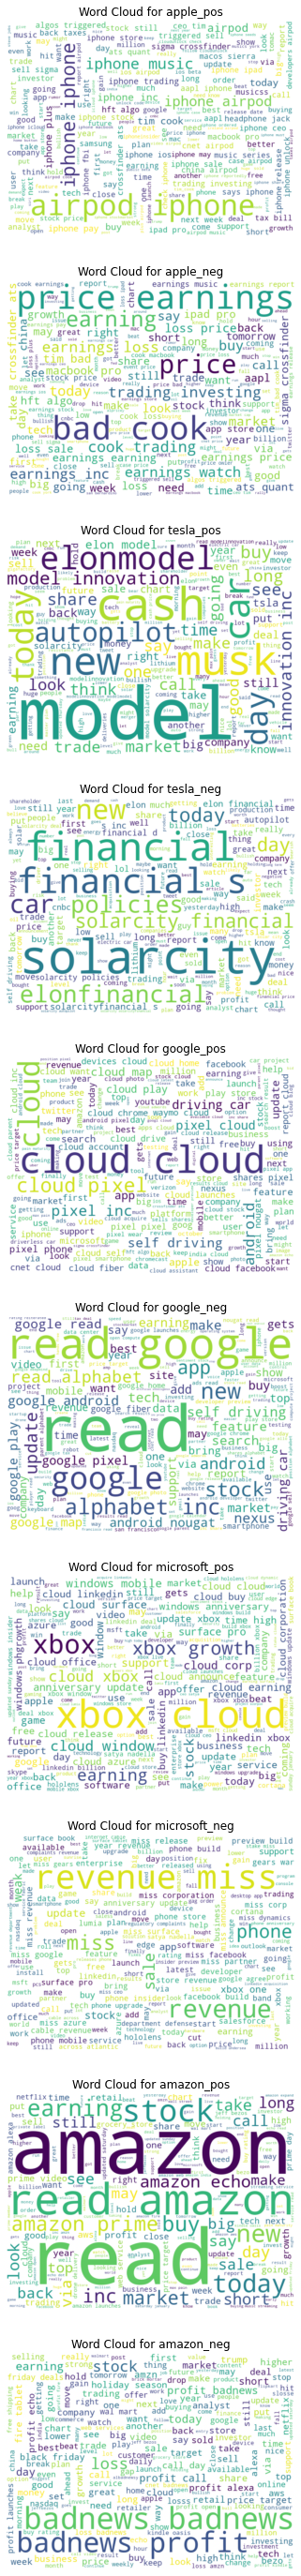

In [98]:

wordclouds = {}
for key, df in dfs.items():
    text = df['processed_text'].str.cat(sep=' ')
    wordclouds[key] = WordCloud(width=800, height=600, background_color='white').generate(text)

# Display the word clouds
fig, axs = plt.subplots(len(wordclouds), 1, figsize=(10, 5*len(wordclouds)))
for idx, (key, wordcloud) in enumerate(wordclouds.items()):
    axs[idx].imshow(wordcloud, interpolation='bilinear')
    axs[idx].axis('off')
    axs[idx].set_title(f"Word Cloud for {key}")
plt.show()
